## 13. What is the distribution of left-handed versus right-handed players?

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

In [2]:
# Find parquet files for home and away teams
home_files= glob.glob(r'../data/raw/*/home_team_[0-9]*.parquet')
away_files= glob.glob(r'../data/raw/*/away_team_[0-9]*.parquet')

In [3]:
# Function to read 'plays' column from parquet file
def read_parquet_file(path):
    return pd.read_parquet(path, columns=['plays'], engine='pyarrow')

In [4]:
# Read home and away files in parallel using 4 threads each
with ThreadPoolExecutor(max_workers=4) as executor:
    df_home_list= list(executor.map(read_parquet_file, home_files))

with ThreadPoolExecutor(max_workers=4) as executor:
    df_away_list= list(executor.map(read_parquet_file, away_files))

In [5]:
# Combine dataframes from home and away teams into one
df_home= pd.concat(df_home_list, ignore_index=True)
df_away= pd.concat(df_away_list, ignore_index=True)
df_all_players= pd.concat([df_home, df_away], ignore_index=True)
df_all_players.head()

,plays
0,right-handed
1,None
2,None
3,right-handed
4,None


In [6]:
# Fill missing 'plays' values and count occurrences
df_all_players= df_all_players.fillna('Not Mentioned')
df_all_players_plays= df_all_players['plays'].value_counts()
df_all_players_plays.head()

plays
Not Mentioned    25370
right-handed     21600
left-handed       2843
Name: count, dtype: int64

In [7]:
# Calculate percentages for each playing hand category
total= np.sum(df_all_players_plays)
right= df_all_players_plays.get('right-handed', 0)/ total* 100
left= df_all_players_plays.get('left-handed', 0)/ total* 100
miss= df_all_players_plays.get('Not Mentioned', 0)/ total* 100

print(f'right-handed: {right:.2f}%')
print(f'left-handed: {left:.2f}%')
print(f'missing: {miss:.2f}%')

right-handed: 43.36%
left-handed: 5.71%
missing: 50.93%


In [8]:
# FILTER OUT MISSING DATA
df_filtered = df_all_players[df_all_players['plays'] != 'Not Mentioned']  # Drop missing values
hand_counts = df_filtered['plays'].value_counts()

# Calculate percentages (only for right & left-handed)
total_known = hand_counts.sum()
right_percent = hand_counts.get('right-handed', 0) / total_known * 100
left_percent = hand_counts.get('left-handed', 0) / total_known * 100

print(f'Right-handed: {right_percent:.1f}%')
print(f'Left-handed: {left_percent:.1f}%')

Right-handed: 88.4%
Left-handed: 11.6%


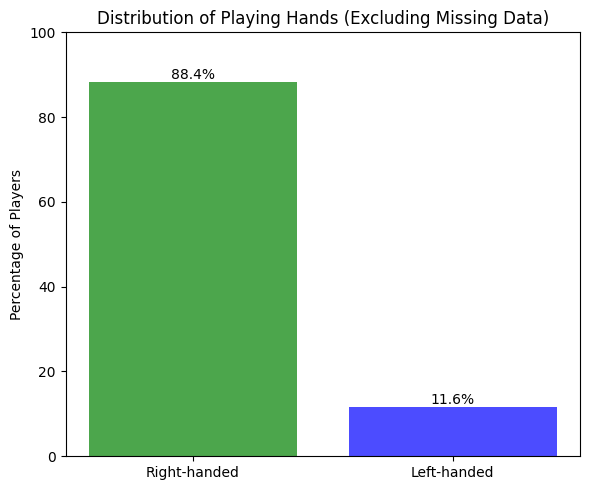

In [9]:
# Plotting (exclude missing data)
labels = ['Right-handed', 'Left-handed']
percentages = [right_percent, left_percent]
colors = ['green', 'blue']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, percentages, color=colors, alpha=0.7)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom')

plt.title('Distribution of Playing Hands (Excluding Missing Data)')
plt.ylabel('Percentage of Players')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('../data/output/figures/img13.png')
plt.show()